In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBMQの基底ゲート

from fractions import Fraction

In [2]:
# 自作ライブラリ
import graphlib
import operation


## 理想的な回路作成

In [3]:
# # 係数の絶対値の分布をプロットする関数
# def show_distribution(state, nqubits):
#     plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
#     plt.xlabel(f'$2^{nqubits}$個のデータ')
#     plt.ylabel('各状態の確率振幅')
#     plt.ylim(0, 1)
#     plt.show()



###　動作の確認
初期状態$|0 \cdots 0\rangle$を作成

In [4]:
# 全体のパラメータ
nqubits = 3
times = 4

In [5]:
import matplotlib.ticker as ticker
state1 = QuantumState(nqubits)
state1.set_zero_state()

次にアダマールゲートを作成する
$$
H = \frac{1}{\sqrt{2}}(|0\rangle \langle 0 | + |1\rangle \langle 0| + |0\rangle \langle 1| + |1\rangle \langle 1|)
$$

In [6]:
# def make_Hadamard(nqubits):
#     Hadamard = QuantumCircuit(nqubits)
#     for i in range(nqubits):
#         Hadamard.add_gate(H(i))
#     return  Hadamard
#
# print(make_Hadamard(3).copy())

このアダマールゲートを初期状態$|00 \cdots 00\rangle$に作用させる。
$$
|s\rangle = (H\otimes \cdots \otimes H)|0 \cdots 0 \rangle \\
= \frac{1}{(\sqrt{2})^n}(|0\rangle + |1\rangle)\otimes \cdots \otimes (|0\rangle + |1\rangle) \\
= \frac{1}{(\sqrt{2})^n}(|00 \cdots 00\rangle + |00\cdots 01\rangle + \cdots + |11 \cdots 10\rangle + |11\cdots 11\rangle)|s\rangle \\
= \frac{1}{(\sqrt{2})^n}\sum^{2^n - 1}_{x = 0} |x\rangle
$$

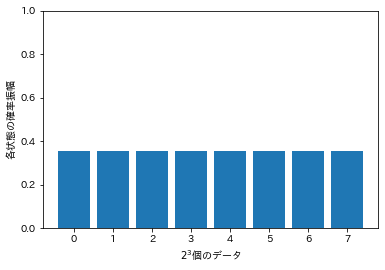

In [7]:
# Hadamard = make_Hadamard(nqubits)
Hadamard = operation.Hadamard(nqubits)
Hadamard.update_quantum_state(state1)

# show_distribution(state1, nqubits)
import  made_graph as graph
graph.show_distribution(state1, nqubits)

次に解に対する反転操作をする、オラクル$U_w$を作成する。

入力$|x\rangle$に対して$x$が解なら、$-1$を掛けて位相を反転し、解でないなら$1$を掛ける。

$$
\begin{cases}
    U_w|x\rangle = |x\rangle (x \neq w) \\
    U_w|w\rangle = -|w\rangle
  \end{cases}
$$

$$
U_w = I - 2 \sum_{w \in \text{解}} |w\rangle \langle w|
$$

In [8]:
# オラクルU_wの作成
# def make_U_w(nqubits):
#     U_w = QuantumCircuit(nqubits)
#     CnZ = to_matrix_gate(Z(nqubits-1))
#     # i-th qubitが全て1の場合だけゲートを作用
#     for i in range(nqubits-1):
#         control_index = i
#         control_with_value = 1
#         CnZ.add_control_qubit(control_index, control_with_value)
#     U_w.add_gate(CnZ)
#     return U_w

これを作用させると$|s\rangle$
$$
U_w |s\rangle = \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} U_w |x\rangle + \frac{1}{(\sqrt{2})^n} U_w |x\rangle \\

= \frac{1}{(\sqrt{2})^n} \sum_{x = 0, x \neq w}^{2^n - 1} |x\rangle - \frac{1}{(\sqrt{2})^n}|w\rangle \\

= \left( |s\rangle - \frac{1}{(\sqrt{2})^n} |w\rangle \right) - \frac{1}{(\sqrt{2})^n} |w\rangle \\

U_w |s\rangle = |s\rangle - \frac{2}{(\sqrt{2})^n} |w\rangle
$$

となる。

In [9]:
fuga = state1.copy()
U_w = operation.make_U_w(nqubits)
U_w.update_quantum_state(fuga)
# print(fuga.get_vector())
print(fuga)

 *** Quantum State ***
 * Qubit Count : 3
 * Dimension   : 8
 * State vector : 
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
 (0.353553,0)
(-0.353553,0)



最後に$|s\rangle$を対象軸にした反転操作$U_s$を定義する

$$
U_s = 2|s\rangle \langle s| - I = H^{\otimes n}(2 |0 \cdots 0\rangle \langle 0 \cdots 0| - I)H^{\otimes n}
$$

$$
\begin{cases}
    U_s |x\rangle = 2\langle s|x|s\rangle - |x\rangle = \frac{2}{\sqrt{2^n}} |x\rangle \\
    U_s |s\rangle = 2\langle s|s|s\rangle - |s\rangle = |s\rangle
 \end{cases}
$$

In [10]:
# # 反転U_sを作る
# def make_U_s(nqubits):
#     U_s = QuantumCircuit(nqubits)
#     for i in range(nqubits):
#         U_s.add_gate(H(i))
#
#     ## 2|0><0| - I の実装
#     U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
#     U_s.add_gate( X(nqubits-1) )
#     ## 全てのi-th qubitが0の場合だけZゲートを作用させる
#     CnZ = to_matrix_gate(Z(nqubits-1))
#     for i in range(nqubits-1):
#         control_index = i
#         control_with_value = 0
#         CnZ.add_control_qubit(control_index, control_with_value)
#     U_s.add_gate( CnZ )
#     U_s.add_gate( X(nqubits-1) )
#
#     for i in range(nqubits):
#         U_s.add_gate(H(i))
#
#     return U_s

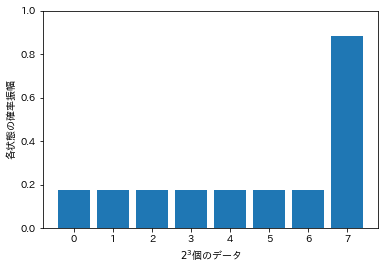

In [11]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

## U_s U_w を作用
# U_s = make_U_s(nqubits)
U_s = operation.make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)
# show_distribution(state1, nqubits)
graph.show_distribution(state1, nqubits)


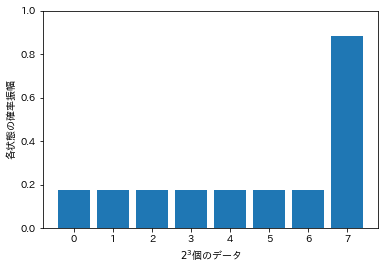

0.8838834764831837


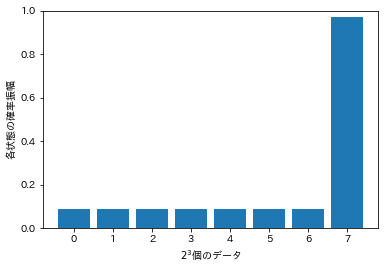

0.9722718241315015


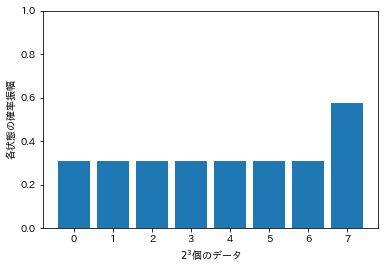

0.5745242597140687


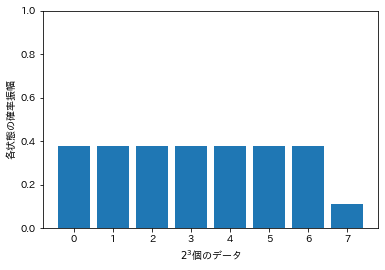

0.11048543456039785


In [12]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state1 = QuantumState(nqubits)
state1.set_zero_state()

Hadamard.update_quantum_state(state1)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    # show_distribution(state1, nqubits)
    graph.show_distribution(state1, nqubits)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

0.8838834764831837
0.9722718241315015
0.5745242597140687
0.11048543456039785


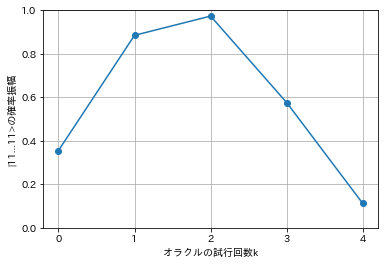

In [13]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)

avg_result = []
hoge = np.linalg.norm(inner_product(state1, target_state))
avg_result.append(hoge)
for i in range(times):
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    fuga = np.linalg.norm(inner_product(state1, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.xlabel('オラクルの試行回数k')
plt.ylabel('|11...11>の確率振幅')
plt.ylim(0, 1)
plt.xticks(np.arange(0, len(avg_result), step=1))
plt.grid()
plt.plot(avg_result, "o-")

In [14]:
def line_graph(result, title):
    plt.title(title)
    plt.plot(result, "o-")
    plt.xlabel('試行回数k')
    plt.ylabel('解の確率振幅')
    plt.ylim(0, 1)
    plt.xticks(np.arange(0, len(result), step=1))
    plt.grid()
    plt.show()


In [15]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Hadamard = operation.Hadamard(nqubits)
    # U_w = make_U_w(nqubits)
    U_w = operation.make_U_w(nqubits)
    # U_s = make_U_s(nqubits)
    U_s = operation.make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    return  result, max_k, result[max_k]

maximal probability 9.722718e-01 is obtained at k = 2


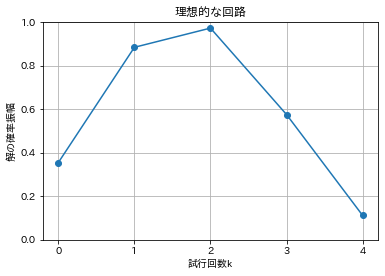

In [16]:
result_array = []
result_theory, k_theory, p_kth= grover(nqubits, times)
line_graph(result_theory, '理想的な回路')

## 任意の回転ゲート
任意の回転ゲートでアダマール演算子を作成する

Qulacsでは任意の回転ゲートを作成する際に、IBMQのOpenQASMを使用する。

以下のコードは、
`U3(対象ビットの添字, \theta, \psi, \lambda)`となっている。
[参考資料](http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id24)
また、対象ビットの添字はQulacsの仕様上、$|00 \cdots 00\rangle$である場合、一番右から0番目の量子ビットになる
[参考資料](https://docs.qulacs.org/ja/latest/intro/4.1_python_tutorial.html?highlight=%E5%AF%BE%E8%B1%A1%E3%83%93%E3%83%83%E3%83%88%E3%81%AE%E6%B7%BB%E3%81%88%E5%AD%97#id3)

$$
U(\theta, \phi, \lambda) = \begin{pmatrix}
\cos{\frac{\theta}{2}} & -e^{i \lambda} \sin{\frac{\theta}{2}} \\
e^{i \phi}\cos{\frac{\theta}{2}} & e^{i (\lambda + \phi)}\cos{\frac{\theta}{2}}
\end{pmatrix}
$$

In [17]:
from qulacs.gate import U3
print(U3(0, np.pi/2, 0, np.pi))

 *** gate info *** 
 * gate name : DenseMatrix
 * target    : 
 0 : commute       
 * control   : 
 * Pauli     : no
 * Clifford  : no
 * Gaussian  : no
 * Parametric: no
 * Diagonal  : no
 * Matrix
           (0.707107,0) (0.707107,-8.65956e-17)
           (0.707107,0) (-0.707107,8.65956e-17)




### 任意の回転ゲートを利用してアダマールゲートを作成
上記の内容を踏まえてアダマールゲートを作成する。
$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}\\
= \begin{pmatrix}
\cos{\frac{\pi}{4}} & -e^{i \pi} \sin{\frac{\pi}{4}} \\
e^{i 0}\cos{\frac{\pi}{4}} & e^{i (\pi + 0)}\cos{\frac{\pi}{4}}
\end{pmatrix} \\
= U(\frac{\pi}{2}, 0, \pi)
$$
これを用いて、以下のように作成する。


In [18]:
def make_revolution_Hadamard(nqubits):
    U_3 = QuantumCircuit(nqubits)
    THETA = np.pi/2
    PHI = 0
    LAMBDA = np.pi
    # 全てのqubitにゲートを作用
    for i in range(nqubits):
        control_index = i
        U_3.add_gate(U3(control_index, THETA, PHI, LAMBDA))
    return U_3

試しに、通常のアダマール演算子と比較してみる。

通常のアダマールゲート


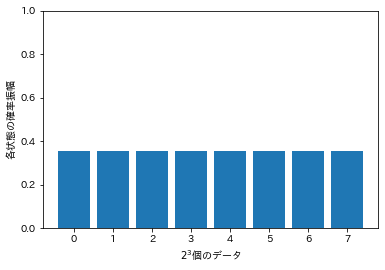

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]
作成したアダマールゲート


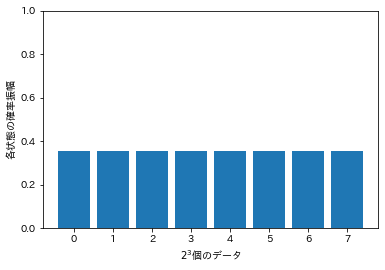

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


In [19]:
# 通常のアダマール演算子を作成し、 初期化した3量子ビットに作用
# Hadamard = make_Hadamard(3)
Hadamard = operation.Hadamard(3)
state1 = QuantumState(3)
state1.set_zero_state()
Hadamard.update_quantum_state(state1)
print('通常のアダマールゲート')
# show_distribution(state1, 3)
graph.show_distribution(state1, 3)
print(state1.get_vector())

# アダマール演算子と同じ振る舞いをするよう作成した回転ゲートを、
# 初期化した3量子ビットに作用
revolution_Hadamard = make_revolution_Hadamard(3)
state2 = QuantumState(3)
state2.set_zero_state()
revolution_Hadamard.update_quantum_state(state2)
print("作成したアダマールゲート")
# show_distribution(state2, 3)
graph.show_distribution(state2, 3)

print(state2.get_vector())


どのくらいの誤差があるか調べる。

In [20]:
state1.get_vector() == state2.get_vector()
# 誤差
absolute_error_array = []
relative_error_array = []
for i in range(len(state1.get_vector())):
    absolute_error = state2.get_vector()[i] - state1.get_vector()[i]
    absolute_error_array.append(absolute_error)
    relative_error = absolute_error / state1.get_vector()[i]
    relative_error_array.append(relative_error)

print(f'絶対誤差：{absolute_error_array}')
print(f'相対誤差：{relative_error_array}')


絶対誤差：[(1.6653345369377348e-16+0j), (1.1102230246251565e-16+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (1.1102230246251565e-16+0j), (5.551115123125783e-17+0j), (5.551115123125783e-17+0j), 0j]
相対誤差：[(4.710277376051326e-16+0j), (3.140184917367551e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (3.140184917367551e-16+0j), (1.5700924586837754e-16+0j), (1.5700924586837754e-16+0j), 0j]


## 任意の回転ゲートを使用してグローバーアルゴリズムを行う。
アダマール演算子と同じ振る舞いをする任意の回転ゲートを使用してグローバーアルゴリズムを行う。

In [21]:
result = []
def revolution_grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Hadamard = make_revolution_Hadamard(nqubits)
    # U_w = make_U_w(nqubits)
    U_w = operation.make_U_w(nqubits)
    # U_s = make_U_s(nqubits)
    U_s = operation.make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    return  result, max_k



[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]


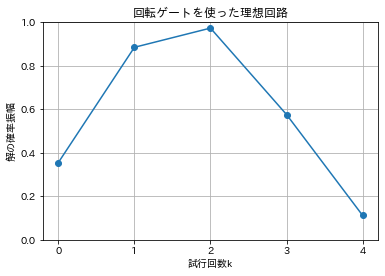

In [22]:
result, max_k = revolution_grover(nqubits, times)
print(result)
line_graph(result, '回転ゲートを使った理想回路')

In [23]:

grover_result = grover(nqubits, times)
print(grover_result)
print(result)

for i in range(len(grover_result)):
    hoge = abs(result[i] - grover_result[i])
    print(f'絶対誤差：{hoge}')


maximal probability 9.722718e-01 is obtained at k = 2
([0.3535533905932737, 0.8838834764831837, 0.9722718241315015, 0.5745242597140687, 0.11048543456039785], 2, 0.9722718241315015)
[0.3535533905932737, 0.883883476483184, 0.9722718241315019, 0.5745242597140691, 0.1104854345603978]
絶対誤差：[0.         0.53033009 0.61871843 0.22097087 0.24306796]
絶対誤差：1.116116523516816
絶対誤差：4.440892098500626e-16


## 作成した回転ゲートをずらしていく

作成した回転ゲートのy軸をずらしていく。
変数`delta`には$\theta$に加える角度を示す

In [24]:
def make_noisy_Hadamard(nqubits, delta):
    U_3 = QuantumCircuit(nqubits)
    THETA = np.pi/2
    PHI = 0
    LAMBDA = np.pi
    # 全てのqubitにゲートを作用
    for i in range(nqubits):
        control_index = i
        U_3.add_gate(U3(control_index, THETA + delta, PHI, LAMBDA))
    return U_3

In [25]:
def noisy_grover(nqubits, operate_times, delta):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_revolution_Hadamard(nqubits)
    Hadamard = make_noisy_Hadamard(nqubits, delta)
    # U_w = make_U_w(nqubits)
    U_w = operation.make_U_w(nqubits)
    # U_s = make_U_s(nqubits)
    U_s = operation.make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    hoge = np.linalg.norm(inner_product(state, target_state))
    result.append(hoge)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)

    max_k = np.argmax(result)
    return  result, max_k, result[max_k]


### 3量子ビットで計算
実際に、$\delta = 0$~$2\pi$を$\theta$に加える

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


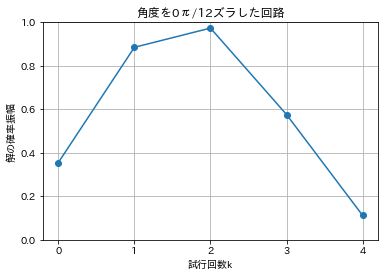

maximal probability 9.722718e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


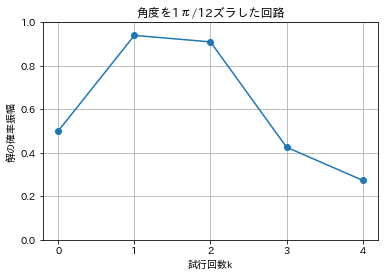

maximal probability 9.387855e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.387855e-01
理想値k_theoryの時の確率:9.088341e-01


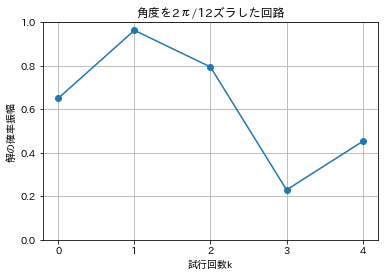

maximal probability 9.620191e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.620191e-01
理想値k_theoryの時の確率:7.935095e-01


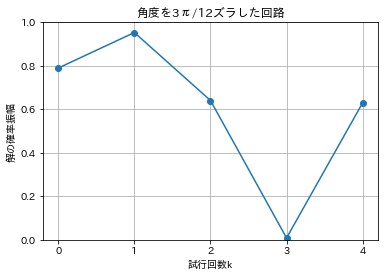

maximal probability 9.519009e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.519009e-01
理想値k_theoryの時の確率:6.392708e-01


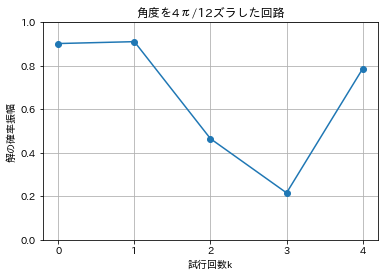

maximal probability 9.098899e-01 is obtained at k = 1
理想値\k_therorとの差:-1
実験値kの時の確率：9.098899e-01
理想値k_theoryの時の確率:4.636137e-01


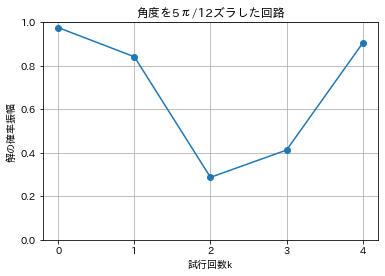

maximal probability 9.745535e-01 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：9.745535e-01
理想値k_theoryの時の確率:2.859961e-01


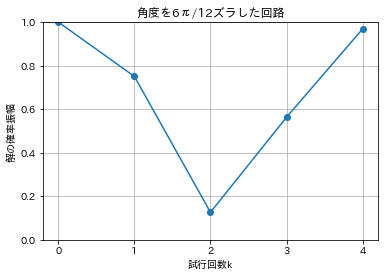

maximal probability 1.000000e+00 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:1.250000e-01


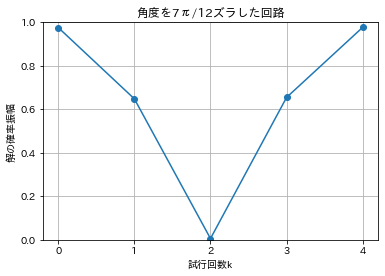

maximal probability 9.756416e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：9.756416e-01
理想値k_theoryの時の確率:4.352187e-03


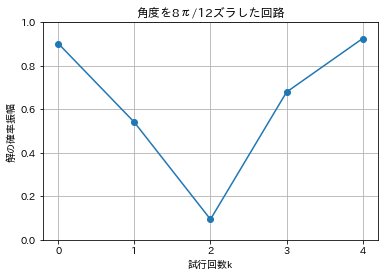

maximal probability 9.244018e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：9.244018e-01
理想値k_theoryの時の確率:9.272274e-02


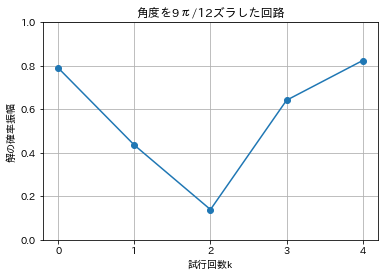

maximal probability 8.230062e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：8.230062e-01
理想値k_theoryの時の確率:1.377029e-01


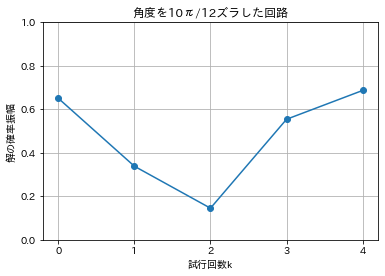

maximal probability 6.855167e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：6.855167e-01
理想値k_theoryの時の確率:1.439905e-01


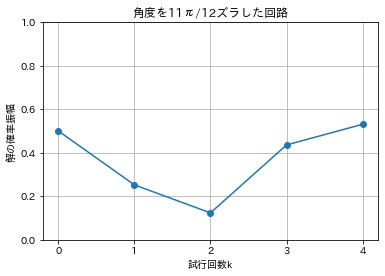

maximal probability 5.299635e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：5.299635e-01
理想値k_theoryの時の確率:1.224774e-01


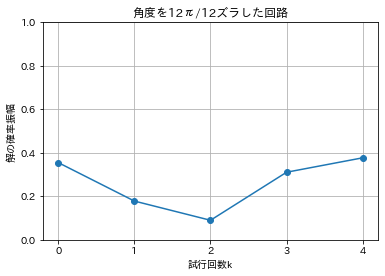

maximal probability 3.756505e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：3.756505e-01
理想値k_theoryの時の確率:8.838835e-02


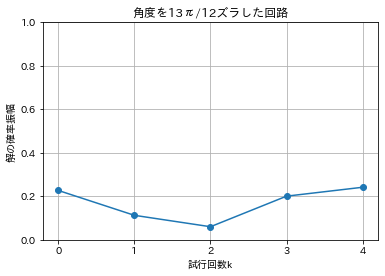

maximal probability 2.402909e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：2.402909e-01
理想値k_theoryの時の確率:5.875898e-02


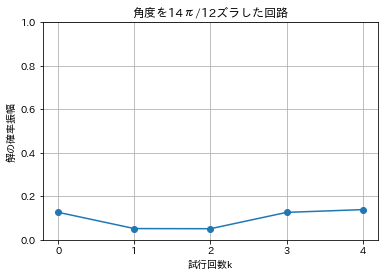

maximal probability 1.374098e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：1.374098e-01
理想値k_theoryの時の確率:4.963929e-02


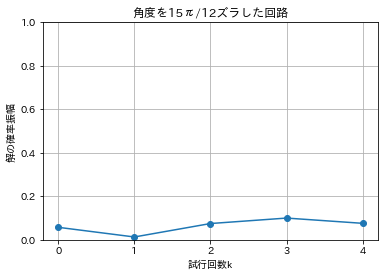

maximal probability 9.857256e-02 is obtained at k = 3
理想値\k_therorとの差:1
実験値kの時の確率：9.857256e-02
理想値k_theoryの時の確率:7.345292e-02


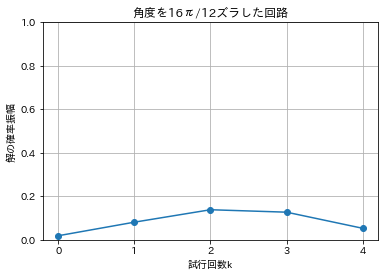

maximal probability 1.369169e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：1.369169e-01
理想値k_theoryの時の確率:1.369169e-01


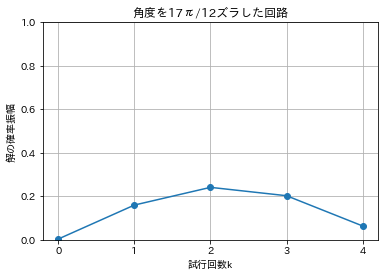

maximal probability 2.398421e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：2.398421e-01
理想値k_theoryの時の確率:2.398421e-01


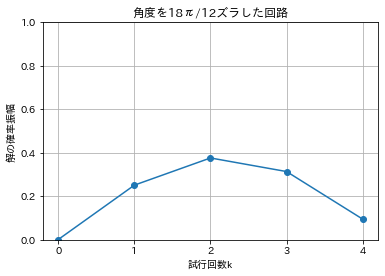

maximal probability 3.750000e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：3.750000e-01
理想値k_theoryの時の確率:3.750000e-01


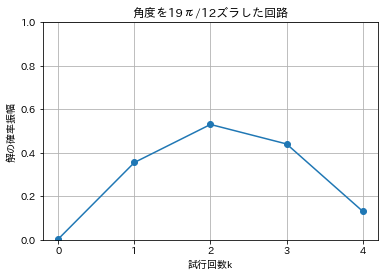

maximal probability 5.290785e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：5.290785e-01
理想値k_theoryの時の確率:5.290785e-01


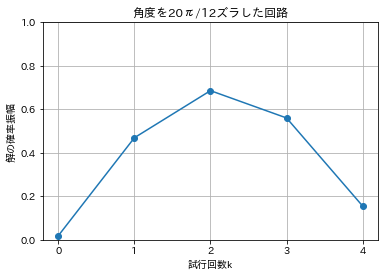

maximal probability 6.845846e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：6.845846e-01
理想値k_theoryの時の確率:6.845846e-01


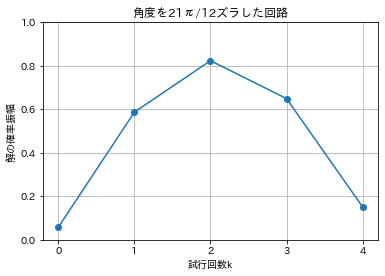

maximal probability 8.224053e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：8.224053e-01
理想値k_theoryの時の確率:8.224053e-01


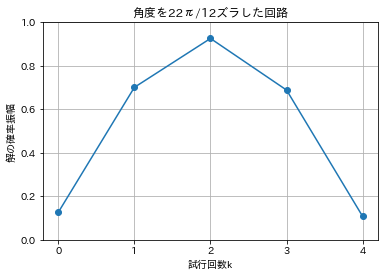

maximal probability 9.246393e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.246393e-01
理想値k_theoryの時の確率:9.246393e-01


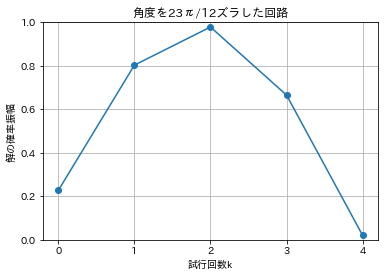

maximal probability 9.772698e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.772698e-01
理想値k_theoryの時の確率:9.772698e-01


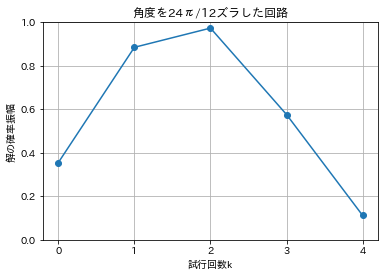

maximal probability 9.722718e-01 is obtained at k = 2
理想値\k_therorとの差:0
実験値kの時の確率：9.722718e-01
理想値k_theoryの時の確率:9.722718e-01


In [26]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

# noises_title = ['0','', '(π/4)',' ',  'π/2', '  ', '3π/4','   ', 'π', '    ', '5π/4', '     ', '3π/2', '      ', '7π/4', '       ', '2π']

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [27]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]

# print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # k_k_theory = abs(max_k - k_theory)
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)


#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

In [28]:
def different_of_k_graph(x, y, yticks_start, yticks_end):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks(noises_title_int, noises_title)
    ax.set_yticks(np.arange(yticks_start, yticks_end, 1))
    ax.grid(axis = 'both')
    ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
    ax.set_ylabel('(k) - (k_theory)', size = 14, weight = "light")
    ax.plot(x, y, "-o")

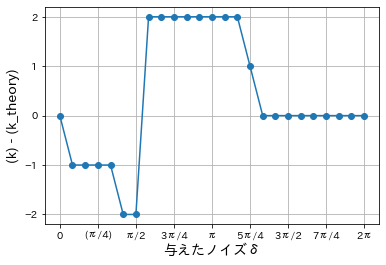

In [29]:
THREEk_k_theory_array = k_k_theory_array
different_of_k_graph(noises, k_k_theory_array, -3, 3)

#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

In [30]:
def P_k_graph(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks(noises_title_int, noises_title)
    ax.set_ylim(0, 1)
    ax.grid(axis = 'both')
    ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
    ax.set_ylabel("解の確率振幅", size = 14, weight = "light")
    ax.plot(x, y, "-o")

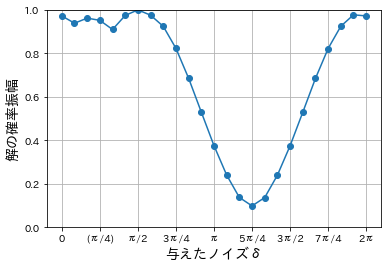

In [31]:
THREE_p_k_array = p_k_array
P_k_graph(noises, p_k_array)


#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる


In [32]:
def P_k_throry_graph(x, y):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks(noises_title_int, noises_title)
    ax.set_ylim(0, 1)
    ax.grid(axis = 'both')
    ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
    ax.set_ylabel("理想値k_{theory}時の解の確率振幅", size = 14, weight = "light")
    ax.plot(x, y, "-o")

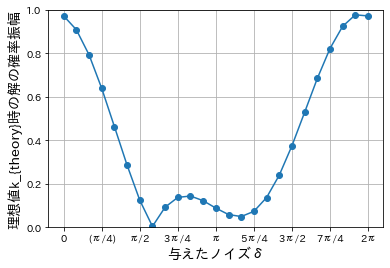

In [33]:
THREE_p_kth_array = p_kth_array
P_k_throry_graph(noises, p_kth_array)

## 5量子ビットで計算

In [34]:
nqubits = 5
times = 10

maximal probability 9.995911e-01 is obtained at k = 4


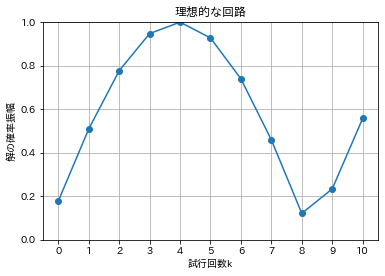

In [35]:
result_array = []
result_theory, k_theory, p_kth= grover(nqubits, times)
line_graph(result_theory, '理想的な回路')

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


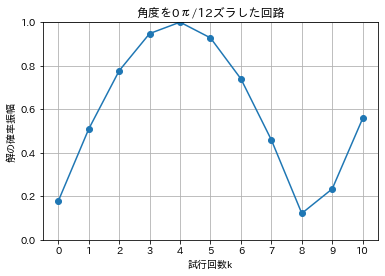

maximal probability 9.995911e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：9.995911e-01
理想値k_theoryの時の確率:9.995911e-01


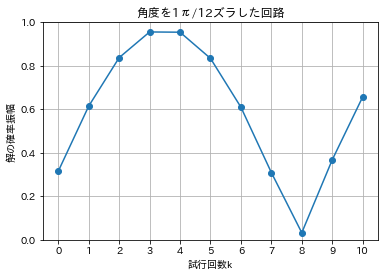

maximal probability 9.545213e-01 is obtained at k = 3
理想値\k_therorとの差:-1
実験値kの時の確率：9.545213e-01
理想値k_theoryの時の確率:9.533471e-01


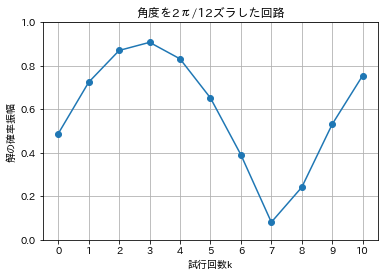

maximal probability 9.067503e-01 is obtained at k = 3
理想値\k_therorとの差:-1
実験値kの時の確率：9.067503e-01
理想値k_theoryの時の確率:8.306726e-01


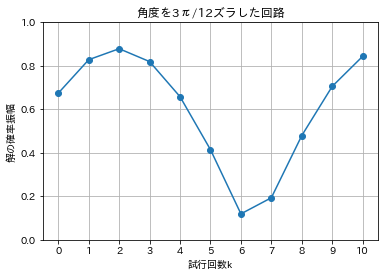

maximal probability 8.774054e-01 is obtained at k = 2
理想値\k_therorとの差:-2
実験値kの時の確率：8.774054e-01
理想値k_theoryの時の確率:6.567220e-01


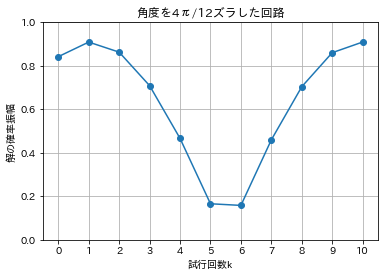

maximal probability 9.081936e-01 is obtained at k = 10
理想値\k_therorとの差:6
実験値kの時の確率：9.081936e-01
理想値k_theoryの時の確率:4.650129e-01


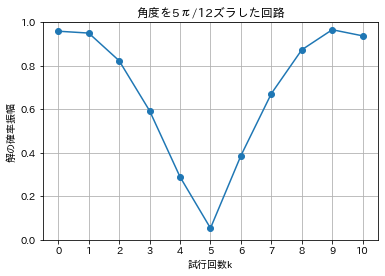

maximal probability 9.648022e-01 is obtained at k = 9
理想値\k_therorとの差:5
実験値kの時の確率：9.648022e-01
理想値k_theoryの時の確率:2.879465e-01


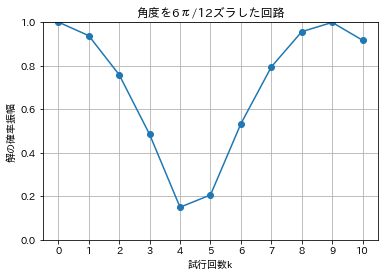

maximal probability 1.000000e+00 is obtained at k = 0
理想値\k_therorとの差:-4
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:1.485596e-01


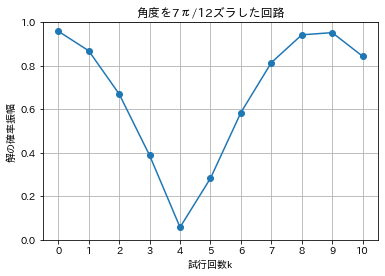

maximal probability 9.579500e-01 is obtained at k = 0
理想値\k_therorとの差:-4
実験値kの時の確率：9.579500e-01
理想値k_theoryの時の確率:5.616978e-02


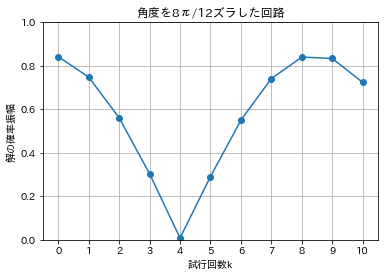

maximal probability 8.408507e-01 is obtained at k = 0
理想値\k_therorとの差:-4
実験値kの時の確率：8.408507e-01
理想値k_theoryの時の確率:6.968704e-03


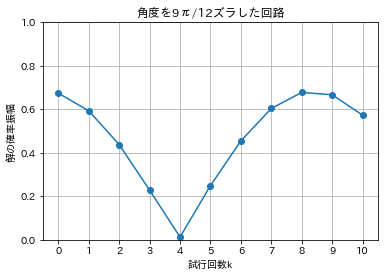

maximal probability 6.764557e-01 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：6.764557e-01
理想値k_theoryの時の確率:1.130921e-02


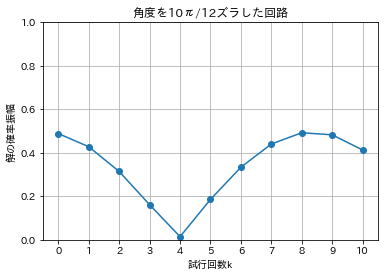

maximal probability 4.909976e-01 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：4.909976e-01
理想値k_theoryの時の確率:1.298584e-02


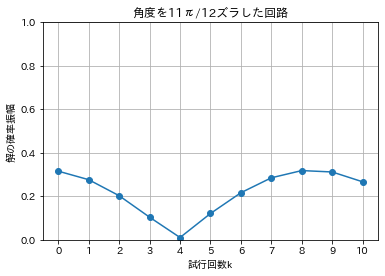

maximal probability 3.169937e-01 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：3.169937e-01
理想値k_theoryの時の確率:9.092975e-03


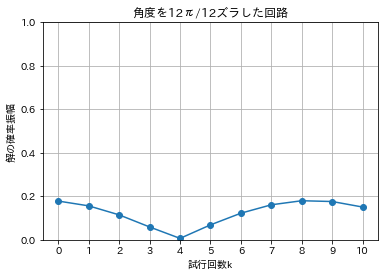

maximal probability 1.783027e-01 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：1.783027e-01
理想値k_theoryの時の確率:5.135846e-03


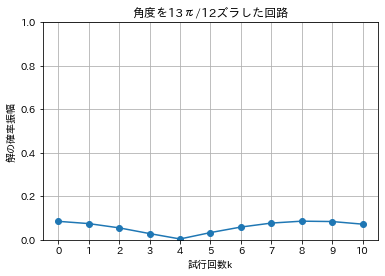

maximal probability 8.433866e-02 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：8.433866e-02
理想値k_theoryの時の確率:2.467039e-03


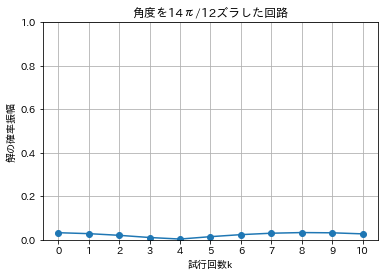

maximal probability 3.186646e-02 is obtained at k = 8
理想値\k_therorとの差:4
実験値kの時の確率：3.186646e-02
理想値k_theoryの時の確率:2.074786e-03


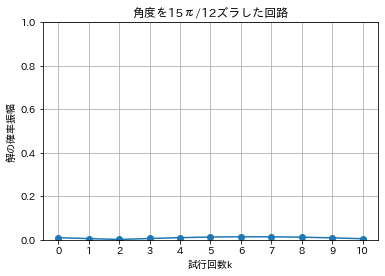

maximal probability 1.267640e-02 is obtained at k = 6
理想値\k_therorとの差:2
実験値kの時の確率：1.267640e-02
理想値k_theoryの時の確率:8.484501e-03


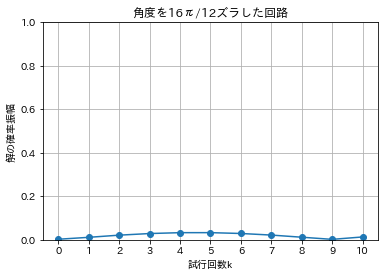

maximal probability 3.151881e-02 is obtained at k = 5
理想値\k_therorとの差:1
実験値kの時の確率：3.151881e-02
理想値k_theoryの時の確率:3.143146e-02


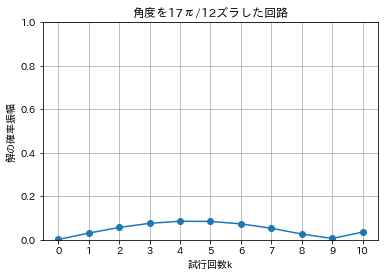

maximal probability 8.400195e-02 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：8.400195e-02
理想値k_theoryの時の確率:8.400195e-02


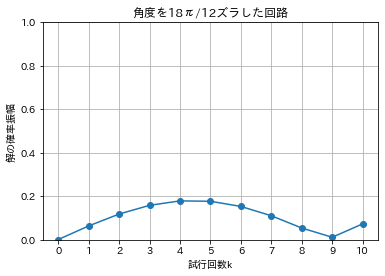

maximal probability 1.776123e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：1.776123e-01
理想値k_theoryの時の確率:1.776123e-01


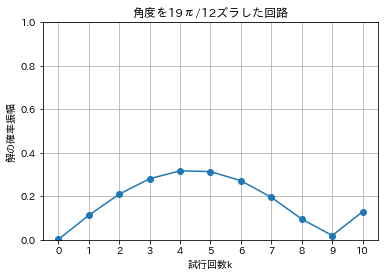

maximal probability 3.157765e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：3.157765e-01
理想値k_theoryの時の確率:3.157765e-01


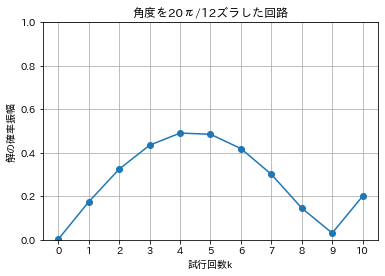

maximal probability 4.894082e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：4.894082e-01
理想値k_theoryの時の確率:4.894082e-01


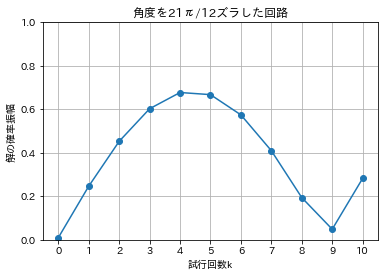

maximal probability 6.760388e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：6.760388e-01
理想値k_theoryの時の確率:6.760388e-01


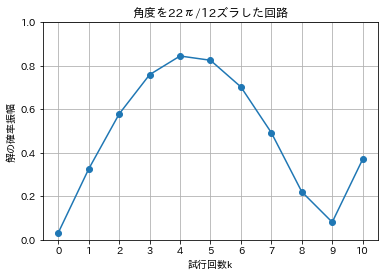

maximal probability 8.439174e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：8.439174e-01
理想値k_theoryの時の確率:8.439174e-01


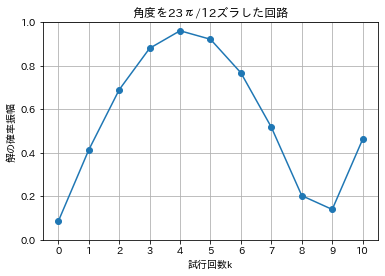

maximal probability 9.600492e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：9.600492e-01
理想値k_theoryの時の確率:9.600492e-01


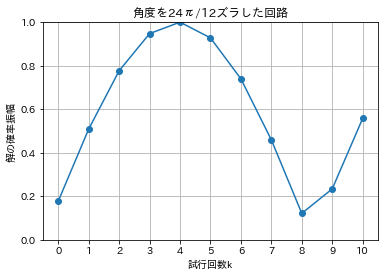

maximal probability 9.995911e-01 is obtained at k = 4
理想値\k_therorとの差:0
実験値kの時の確率：9.995911e-01
理想値k_theoryの時の確率:9.995911e-01


In [36]:
noises_title = ['0','', '(π/4)',' ',  'π/2', '  ', '3π/4','   ', 'π', '    ', '5π/4', '     ', '3π/2', '      ', '7π/4', '       ', '2π']

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [37]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # k_k_theory = abs(max_k - k_theory)
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

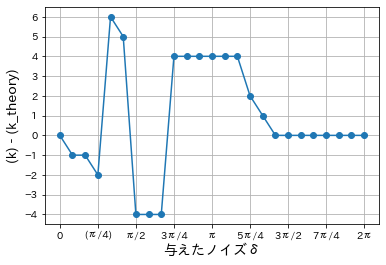

In [38]:
FIVE_k_k_theory_array = k_k_theory_array
different_of_k_graph(noises, k_k_theory_array, -5, 7)
# different_of_k_graph(noises, k_k_theory_array, 8, 4)

#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

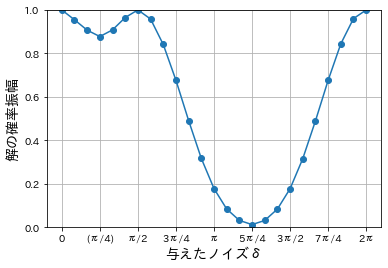

In [39]:
FIVE_p_k_array = p_k_array
P_k_graph(noises, p_k_array)

#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる

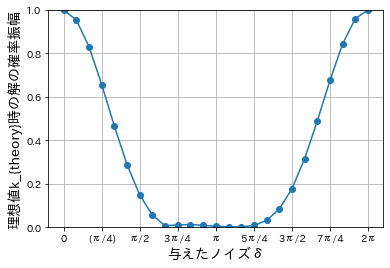

In [40]:
FIVE_p_kth_array = p_kth_array
P_k_throry_graph(noises, p_kth_array)

## 10量子ビットで計算

In [41]:
nqubits = 10
times = 27

maximal probability 9.997306e-01 is obtained at k = 25


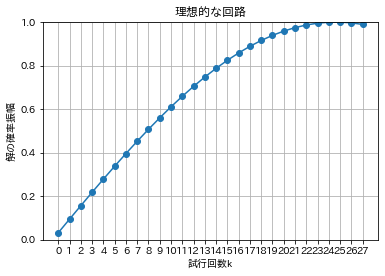

In [42]:
result_array = []
result_theory, k_theory, p_kth= grover(nqubits, times)
line_graph(result_theory, '理想的な回路')

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


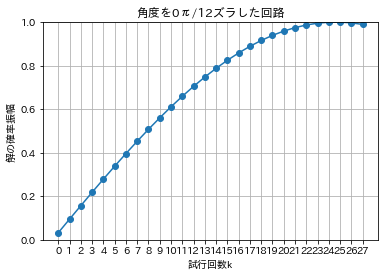

maximal probability 9.997306e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：9.997306e-01
理想値k_theoryの時の確率:9.997306e-01


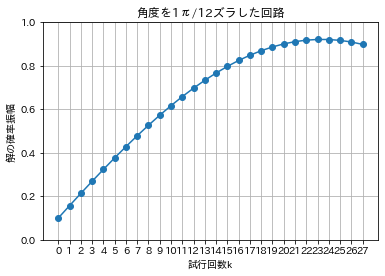

maximal probability 9.200447e-01 is obtained at k = 23
理想値\k_therorとの差:-2
実験値kの時の確率：9.200447e-01
理想値k_theoryの時の確率:9.157930e-01


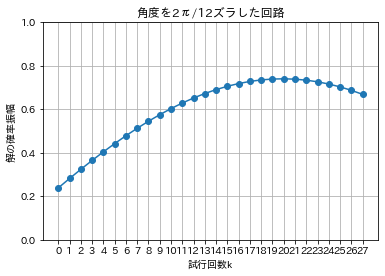

maximal probability 7.390740e-01 is obtained at k = 20
理想値\k_therorとの差:-5
実験値kの時の確率：7.390740e-01
理想値k_theoryの時の確率:7.018417e-01


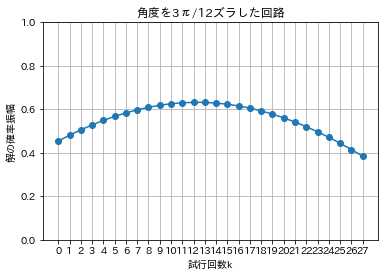

maximal probability 6.308159e-01 is obtained at k = 12
理想値\k_therorとの差:-13
実験値kの時の確率：6.308159e-01
理想値k_theoryの時の確率:4.427433e-01


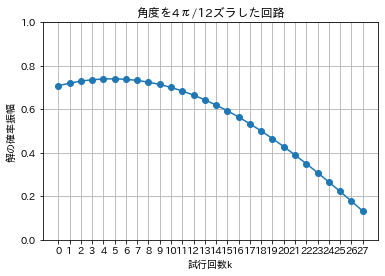

maximal probability 7.389825e-01 is obtained at k = 5
理想値\k_therorとの差:-20
実験値kの時の確率：7.389825e-01
理想値k_theoryの時の確率:2.209940e-01


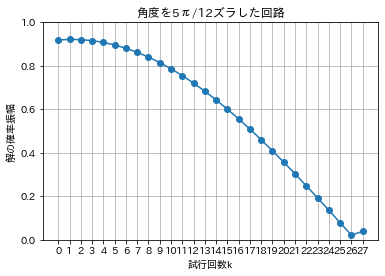

maximal probability 9.202572e-01 is obtained at k = 1
理想値\k_therorとの差:-24
実験値kの時の確率：9.202572e-01
理想値k_theoryの時の確率:7.751401e-02


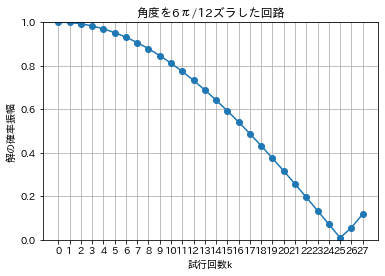

maximal probability 1.000000e+00 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:8.041815e-03


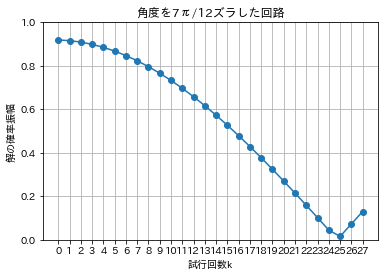

maximal probability 9.176682e-01 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：9.176682e-01
理想値k_theoryの時の確率:1.431740e-02


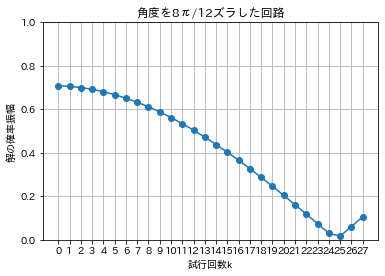

maximal probability 7.070299e-01 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：7.070299e-01
理想値k_theoryの時の確率:1.544195e-02


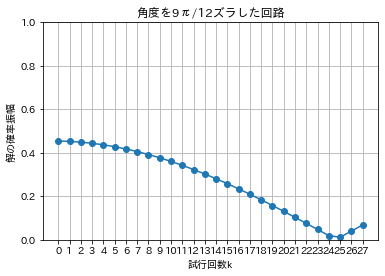

maximal probability 4.530576e-01 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：4.530576e-01
理想値k_theoryの時の確率:1.045372e-02


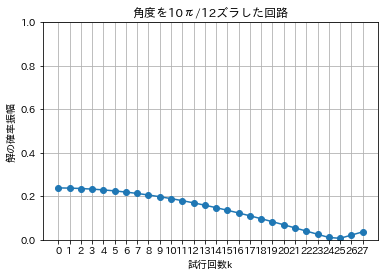

maximal probability 2.373047e-01 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：2.373047e-01
理想値k_theoryの時の確率:5.509445e-03


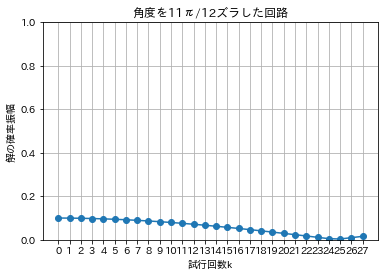

maximal probability 9.877944e-02 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：9.877944e-02
理想値k_theoryの時の確率:2.293898e-03


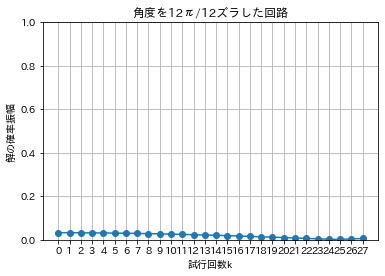

maximal probability 3.125000e-02 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：3.125000e-02
理想値k_theoryの時の確率:7.257014e-04


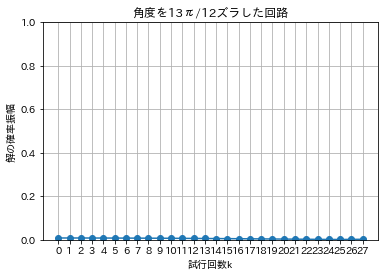

maximal probability 6.989905e-03 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：6.989905e-03
理想値k_theoryの時の確率:1.623212e-04


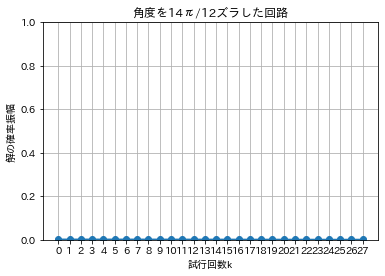

maximal probability 9.765625e-04 is obtained at k = 0
理想値\k_therorとの差:-25
実験値kの時の確率：9.765625e-04
理想値k_theoryの時の確率:2.132871e-05


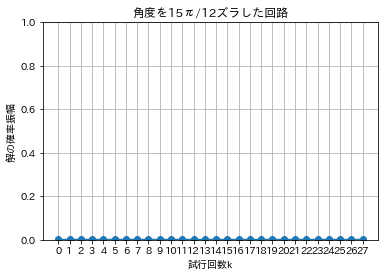

maximal probability 9.378768e-05 is obtained at k = 12
理想値\k_therorとの差:-13
実験値kの時の確率：9.378768e-05
理想値k_theoryの時の確率:6.582564e-05


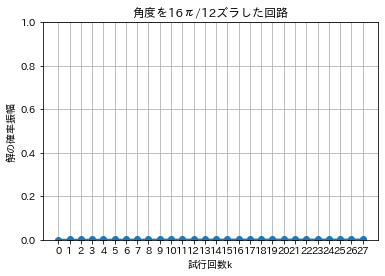

maximal probability 9.769768e-04 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：9.769768e-04
理想値k_theoryの時の確率:9.769768e-04


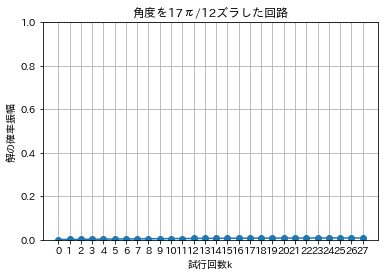

maximal probability 6.993094e-03 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：6.993094e-03
理想値k_theoryの時の確率:6.993094e-03


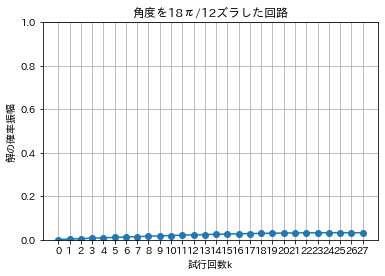

maximal probability 3.126426e-02 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：3.126426e-02
理想値k_theoryの時の確率:3.126426e-02


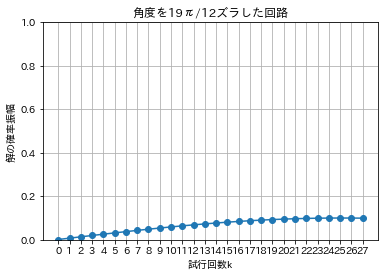

maximal probability 9.882451e-02 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：9.882451e-02
理想値k_theoryの時の確率:9.882451e-02


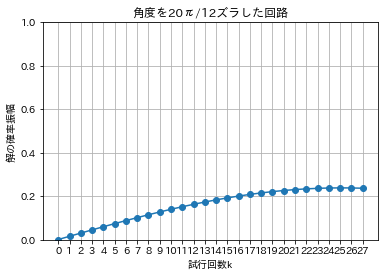

maximal probability 2.374129e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：2.374129e-01
理想値k_theoryの時の確率:2.374129e-01


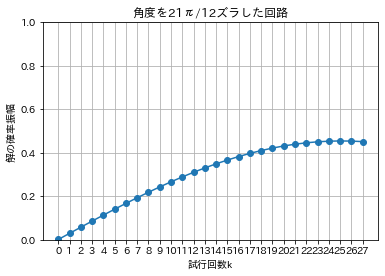

maximal probability 4.532628e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：4.532628e-01
理想値k_theoryの時の確率:4.532628e-01


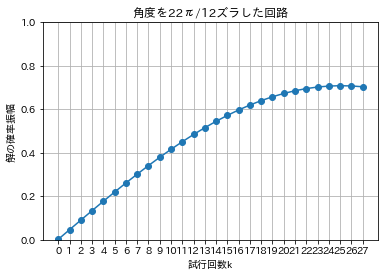

maximal probability 7.073298e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：7.073298e-01
理想値k_theoryの時の確率:7.073298e-01


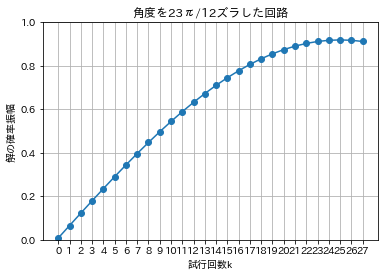

maximal probability 9.179246e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：9.179246e-01
理想値k_theoryの時の確率:9.179246e-01


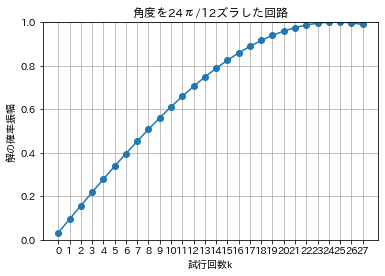

maximal probability 9.997306e-01 is obtained at k = 25
理想値\k_therorとの差:0
実験値kの時の確率：9.997306e-01
理想値k_theoryの時の確率:9.997306e-01


In [43]:
noises_title = ['0','', '(π/4)',' ',  'π/2', '  ', '3π/4','   ', 'π', '    ', '5π/4', '     ', '3π/2', '      ', '7π/4', '       ', '2π']

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]

    line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

In [44]:
noises = []
noises_array = []
n = 12
for i in range(0, 2*n + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

noises_title = ['0', '(π/4)',  'π/2', '3π/4', 'π', '5π/4', '3π/2',  '7π/4',  '2π']
noises_title_int = [0, (np.pi/4),  np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2,  7*np.pi/4,  2*np.pi]

print(f'noises:{noises}')

k_k_theory_array = []
p_k_array = []
p_kth_array = []

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    p_k = result[max_k]
    p_kth = result[k_theory]
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

noises:[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.3089969389957472, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.6179938779914944, 2.8797932657906435, 3.141592653589793, 3.4033920413889427, 3.665191429188092, 3.926990816987241, 4.1887902047863905, 4.4505895925855405, 4.71238898038469, 4.974188368183839, 5.235987755982989, 5.497787143782138, 5.759586531581287, 6.021385919380436, 6.283185307179586]


#### $k - k_{\text{theory}}$のグラフ化
理想的なグローバーの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$と、実験で得られてたグローバーの$U_s$, $U_w$を作用させる回数$k$の差が与えたノイズ$\delta_y$でどのように変化するか見てみる。

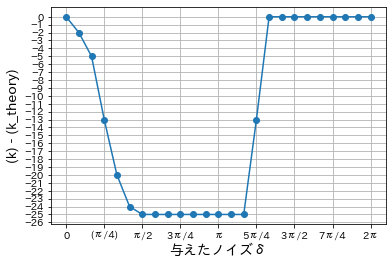

In [45]:
TEN_k_k_theory_array = k_k_theory_array
different_of_k_graph(noises, k_k_theory_array, -27, 1)

#### $P(k)$のグラフ化
ノイズのあるグローバについて、$U_s$, $U_w$を作用させる回数$k$の時の確率がノイズ$\delta_y$でどのように変化するか見てみる

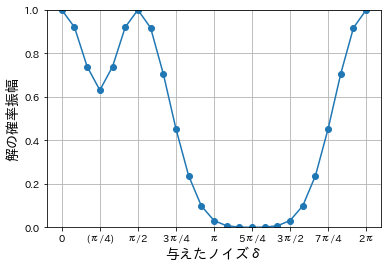

In [46]:
TEN_p_k_array = p_k_array
P_k_graph(noises, p_k_array)

#### $P(k_{\text{theory})$のグラフ化
ノイズのあるグローバについて、理想的なグローバの$U_s$, $U_w$を作用させる回数$k_{\text{theory}}$の時、確率がノイズ$\delta_y$でどのように変化するのか見てみる

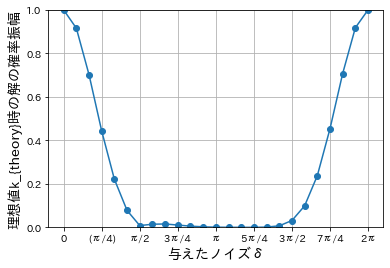

In [47]:
TEN_p_kth_array = p_kth_array
P_k_throry_graph(noises, p_kth_array)

## グラフを重ねてみる

#### $k - k_{\text{theory}}$のグラフを重ねてみる

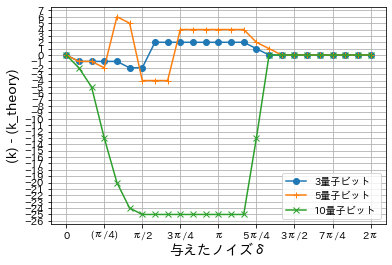

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.set_yticks(np.arange(-27, 8, 1))
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("(k) - (k_theory)", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREEk_k_theory_array, "-o", label = l1)
ax.plot(x, FIVE_k_k_theory_array, "-+", label = l2)
ax.plot(x, TEN_k_k_theory_array, "-x", label = l3)
ax.legend(loc = 0)

#### $P(k)$のグラフ化

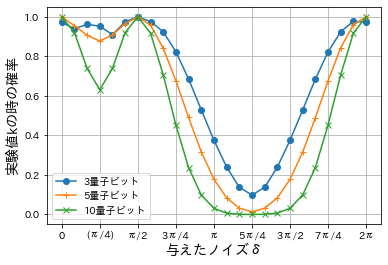

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("実験値kの時の確率", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREE_p_k_array, "-o", label = l1)
ax.plot(x, FIVE_p_k_array, "-+", label = l2)
ax.plot(x, TEN_p_k_array, "-x", label = l3)
ax.legend(loc = 0)

#### $P(k_{\text{\theta})$のグラフ化

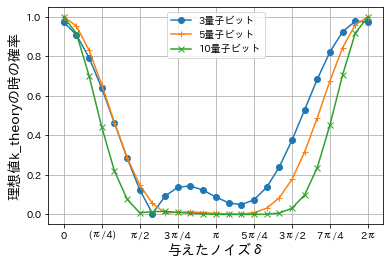

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = noises
ax.set_xticks(noises_title_int, noises_title)
ax.grid(axis = 'both')
ax.set_xlabel("与えたノイズδ", size = 14, weight = "light")
ax.set_ylabel("理想値k_theoryの時の確率", size = 14, weight = "light")
l1, l2, l3 = "3量子ビット", "5量子ビット", "10量子ビット"
ax.plot(x, THREE_p_kth_array, "-o", label = l1)
ax.plot(x, FIVE_p_kth_array, "-+", label = l2)
ax.plot(x, TEN_p_kth_array, "-x", label = l3)
ax.legend(loc = 0)


## $\frac{\pi}{2}$とその直前直後のグラフ
$\frac{\pi}{2}$とその直前、直後のグラフを作成し、その違いを見てみる

maximal probability 9.722718e-01 is obtained at k = 2


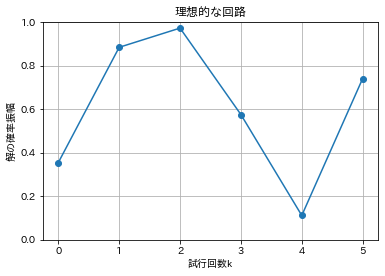

In [51]:
nqubits = 3
times = 5

result_array = []
result_theory, k_theory, p_kth= grover(nqubits, times)
line_graph(result_theory, '理想的な回路')

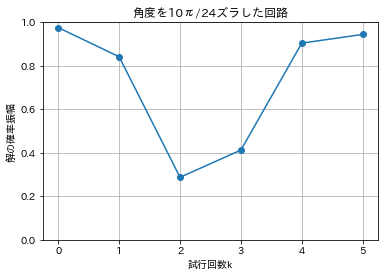

maximal probability 9.745535e-01 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：9.745535e-01
理想値k_theoryの時の確率:9.722718e-01


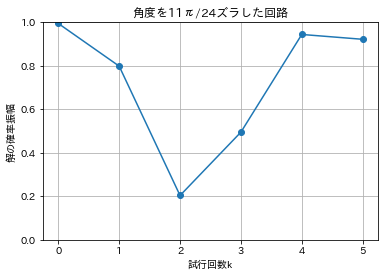

maximal probability 9.935905e-01 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：9.935905e-01
理想値k_theoryの時の確率:9.722718e-01


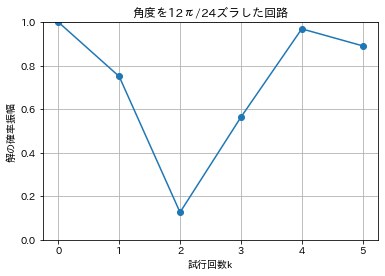

maximal probability 1.000000e+00 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：1.000000e+00
理想値k_theoryの時の確率:9.722718e-01


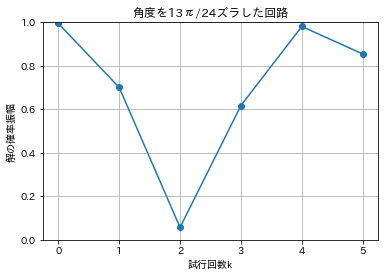

maximal probability 9.935905e-01 is obtained at k = 0
理想値\k_therorとの差:-2
実験値kの時の確率：9.935905e-01
理想値k_theoryの時の確率:9.722718e-01


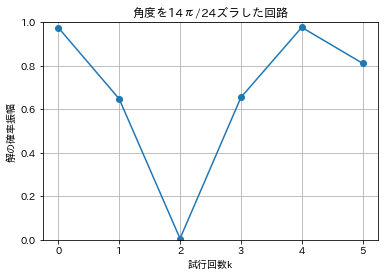

maximal probability 9.756416e-01 is obtained at k = 4
理想値\k_therorとの差:2
実験値kの時の確率：9.756416e-01
理想値k_theoryの時の確率:9.722718e-01


In [52]:
noises = []
noises_array = []
n = 24
for i in range(10, 14 + 1):
    sample = np.pi * i
    result = sample / n
    noises.append(result)
    noises_array.append(f"{i}π/{n}")

for i in range(len(noises)):
    result, max_k, p_k = noisy_grover(nqubits, times, noises[i])
    k_k_theory = max_k - k_theory
    # p_k = result[max_k]
    # p_kth = result[k_theory]

    line_graph(result, f'角度を{noises_array[i]}ズラした回路')
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k}')
    print(f'理想値\k_therorとの差:{k_k_theory}')
    print(f'実験値kの時の確率：{p_k:5e}')
    print(f'理想値k_theoryの時の確率:{p_kth:5e}')
    k_k_theory_array.append(k_k_theory)
    p_k_array.append(p_k)
    p_kth_array.append(p_kth)

## δ = πの時の状態

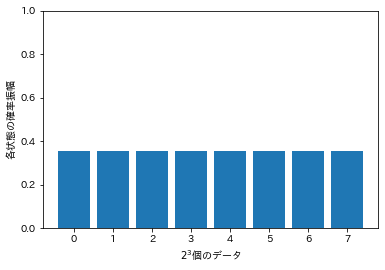

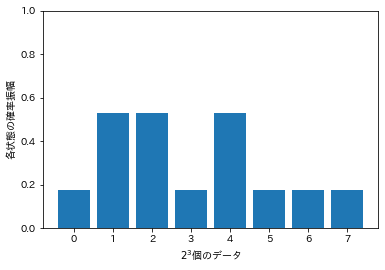

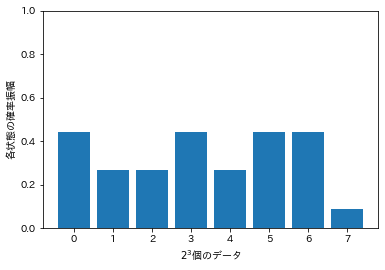

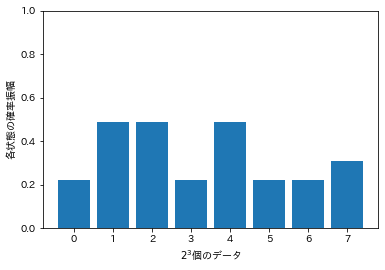

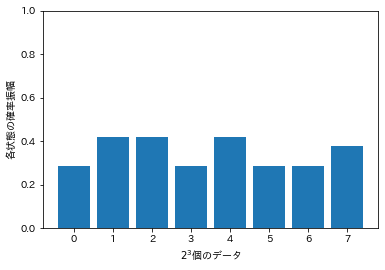

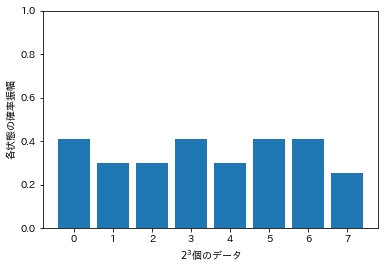

In [53]:
## 初期状態の準備
state1 = QuantumState(nqubits)
state1.set_zero_state()
Hadamard = make_noisy_Hadamard(3, np.pi)
Hadamard.update_quantum_state(state1)
# show_distribution(state1, nqubits)
graph.show_distribution(state1, nqubits)

## U_s U_w を作用
# U_s = make_U_s(nqubits)
U_s = operation.make_U_s(nqubits)
U_w.update_quantum_state(state1)
U_s.update_quantum_state(state1)
# show_distribution(state1, nqubits)
graph.show_distribution(state1, nqubits)

for _ in range(4):
    # U_s = make_U_s(nqubits)
    U_s = operation.make_U_s(nqubits)
    U_w.update_quantum_state(state1)
    U_s.update_quantum_state(state1)
    # show_distribution(state1, nqubits)
    graph.show_distribution(state1, nqubits)
